# Zero-shot reference mapping tutorial with scGPT

## Import scGPT and dependencies

In [2]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


faiss not installed! We highly recommend installing it for fast similarity search.
To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss


Load the dataset, you may download the dataset from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). We set the columns storing gene name columns, batch key and cell type key.

In [90]:
import anndata as ad

model_dir = Path("../../save/scGPT_human")
#adata = sc.read_h5ad('../../data/covid/batch_covid_subsampled_train.h5ad')
ada = sc.read_h5ad('../../data/readySeu_hrpi_GOOD.h5ad')
#test_adata = sc.read_h5ad('../../data/covid/batch_covid_subsampled_test.h5ad')
adata = ad.AnnData(
    X=ada.X.copy(),
    obs=ada.obs.copy(),
    var=ada.var.copy()
)

cell_type_key = "cluster"
gene_col = "names"

In [91]:
mapa = pd.read_csv('../../data/gene_info.csv',index_col=0)
mapa = mapa.set_index('feature_id')

def f(x):
    try:
        return mapa.loc[x]['feature_name']
    except:
        return -1
        
adata.var['names'] = adata.var.name.apply(lambda x: f(x))
adata = adata[:,adata.var.names!=-1]

#adata.var = adata.var.set_index('names')

adata.X = adata.X.toarray()

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Embed the reference dataset

In [78]:
# from scgpt.preprocess import Preprocessor
# # Preprocess the data following the scGPT data pre-processing pipeline
# preprocessor = Preprocessor(
#     use_key="X",  # the key in adata.layers to use as raw data
#     filter_gene_by_counts=1,  # step 1
#     filter_cell_by_counts=False,  # step 2
#     normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
#     result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
#     log1p=True,  # 4. whether to log1p the normalized data
#     result_log1p_key="X_log1p",
#     subset_hvg=2000,  # 5. whether to subset the raw data to highly variable genes
#     hvg_flavor="seurat_v3",
#     binning=51,  # 6. whether to bin the raw data and to what number of bins
#     result_binned_key="X",  # the key in adata.layers to store the binned data
# )
# preprocessor(adata)
# adata.X = adata.layers['X']

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - WARNING - The input data seems to be already log1p transformed. Set `log1p=False` to avoid double log1p transform.
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.


/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


scGPT - INFO - Binning data ...


In [94]:
adata.X = adata.X.toarray()

In [92]:
adata.obsm = dict()

In [101]:
sc.pp.highly_variable_genes(adata,subset=True,n_top_genes=2000)

In [102]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,return_new_adata=True
)

scGPT - INFO - match 2000/2000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 572/572 [00:15<00:00, 36.95it/s]
/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [103]:
adata.obsm['X_scGPT'] = ref_embed_adata.X

## Visualize the embeddings

We visualize the embeddings from query and reference datasets using UMAP

In [104]:
adata = adata[~adata.obs.library.isin(['NR','PR','FM']),:].copy()

In [105]:
sc.pp.neighbors(adata, use_rep="X_scGPT")
sc.tl.umap(adata)

In [106]:
import matplotlib.pyplot as plt

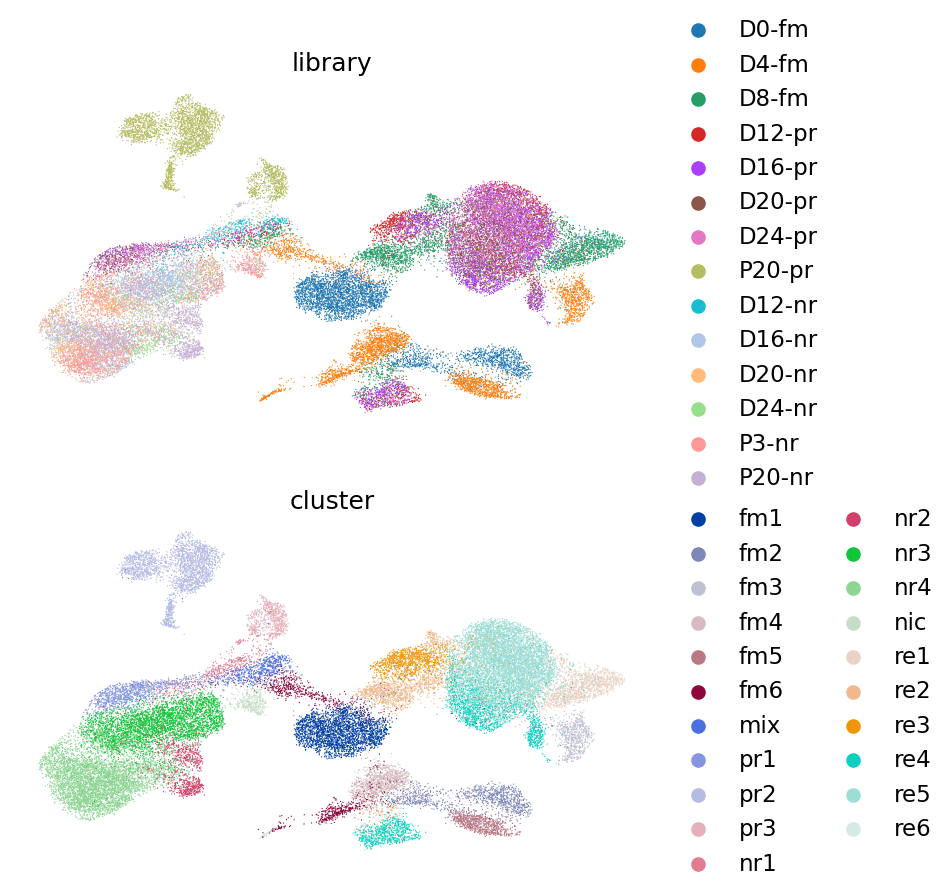

In [107]:
sc.pl.umap(
    adata, color=['library', 'cluster'], wspace=0.4, frameon=False, ncols=1,show=False
)
plt.savefig('./umapFibro.pdf',bbox_inches='tight')

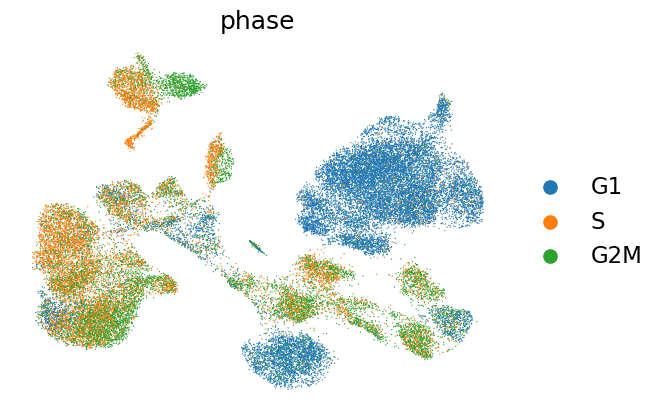

<Figure size 640x480 with 0 Axes>

In [88]:
sc.pl.umap(
    adata, color=['phase'], wspace=0.4, frameon=False, ncols=1
)